## Setup

In [1]:
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
baseball = pd.read_csv('data/baseball.csv')
baseball = baseball.drop(['Name', 'Age', 'Name-additional'], axis = 1)
baseball['Salary'] = baseball['Salary'].str.replace('$', '').astype(float)

baseball['Pos_C'] = baseball['Position'].apply(lambda x: 1 if 'C' in x else 0)
baseball['Pos_1B'] = baseball['Position'].apply(lambda x: 1 if '1B' in x else 0)
baseball['Pos_2B'] = baseball['Position'].apply(lambda x: 1 if '2B' in x else 0)
baseball['Pos_3B'] = baseball['Position'].apply(lambda x: 1 if '3B' in x else 0)
baseball['Pos_SS'] = baseball['Position'].apply(lambda x: 1 if 'SS' in x else 0)
baseball['Pos_OF'] = baseball['Position'].apply(lambda x: 1 if 'OF' in x else 0)

baseball['Num_Pos'] = baseball[['Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF']].sum(axis = 1)
baseball['R/AB'] = baseball['R'] / baseball['AB']
baseball['2B/AB'] = baseball['2B'] / baseball['AB']
baseball['3B/AB'] = baseball['3B'] / baseball['AB']
baseball['HR/AB'] = baseball['HR'] / baseball['AB']
baseball['RBI/AB'] = baseball['RBI'] / baseball['AB']
baseball['BB/PA'] = baseball['BB'] / baseball['PA']
baseball['SB - CS'] = baseball['SB'] - baseball['CS']
baseball['BB - SO'] = baseball['BB'] - baseball['SO'] # measures a batters eye
baseball['E/Def-Inn'] = baseball['E'] / baseball['Def-Inn']
baseball['DP/Def-Inn'] = baseball['DP'] / baseball['Def-Inn']

baseball = baseball.drop(['Position', 'Def-Inn', 'PO', 'A', 'E', 'DP', 'PA', 'AB', 'R', 'H', 
                          '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB'], axis = 1)

X = baseball.drop(['Salary'], axis = 1)
y = baseball['Salary']

In [3]:
cat_columns = ['Tm', 'Lg', 'Acquired', 'Bat']
num_columns = [col for col in X.columns if col not in cat_columns + ['Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF']]

cat_transformer = Pipeline(
    steps = [
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

num_transformer = Pipeline(
    steps = [
        ('scale', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ], remainder = 'passthrough'
)

X_transform = preprocessor.fit_transform(X)

selected_features = np.concatenate([
    np.array(num_columns),
    np.array(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(cat_columns)),
    np.array(['Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF'])
])


## EDA

In [4]:
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [5]:
# sns.pairplot(baseball)
kmeans = KMeans(n_clusters = 4, n_init = 'auto')
kmeans.fit(X_transform)

baseball['cluster'] = kmeans.labels_

Text(0, 0.5, 'WCSS')

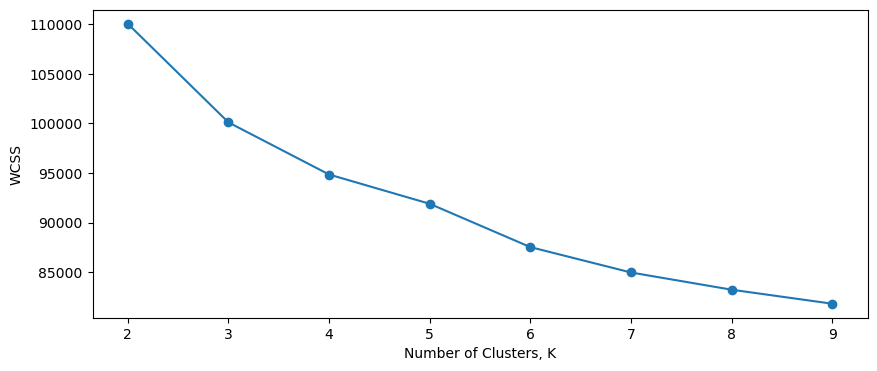

In [6]:
kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=621).fit(X_transform)
                for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(10,4))
plt.plot(range(2, 10),inertias,marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS')

<Axes: xlabel='RBI/AB', ylabel='WAR'>

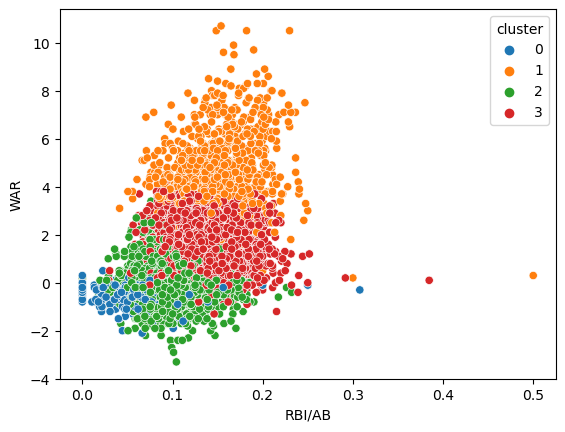

In [7]:
sns.scatterplot(baseball, x = 'RBI/AB', y = 'WAR', hue = 'cluster', palette = 'tab10')

<Axes: xlabel='Salary', ylabel='Bat'>

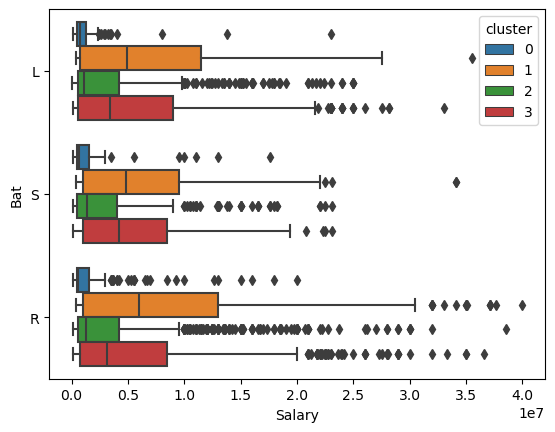

In [8]:
sns.boxplot(baseball, y = 'Bat', x = 'Salary', hue = 'cluster')

<Axes: xlabel='Salary', ylabel='Acquired'>

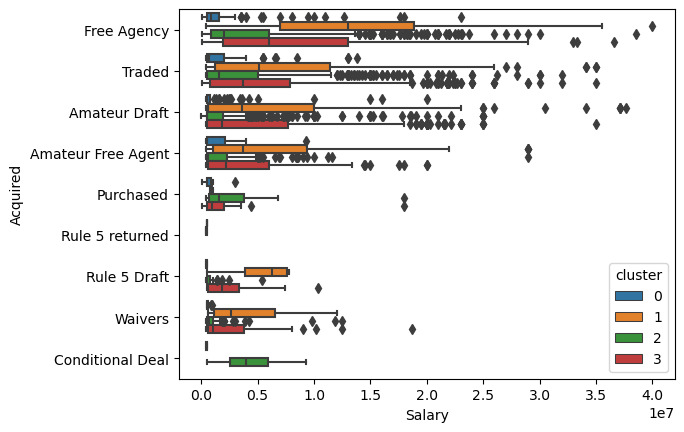

In [9]:
sns.boxplot(baseball, y = 'Acquired', x = 'Salary', hue = 'cluster')

In [10]:
# cluster 0
cluster_0 = baseball[baseball['cluster'] == 0]

# cluster 1
cluster_1 = baseball[baseball['cluster'] == 1]

# cluster 2
cluster_2 = baseball[baseball['cluster'] == 2]

# cluster 3
cluster_3 = baseball[baseball['cluster'] == 3]

print('CLUSTER 0')
print(cluster_0['Salary'].describe())
print('CLUSTER 1')
print(cluster_1['Salary'].describe())
print('CLUSTER 2')
print(cluster_2['Salary'].describe())
print('CLUSTER 3')
print(cluster_3['Salary'].describe())

CLUSTER 0
count    3.620000e+02
mean     1.692284e+06
std      2.980345e+06
min      1.000000e+05
25%      5.095250e+05
50%      6.425000e+05
75%      1.400000e+06
max      2.300000e+07
Name: Salary, dtype: float64
CLUSTER 1
count    8.060000e+02
mean     7.969293e+06
std      8.185871e+06
min      4.000000e+05
25%      7.506250e+05
50%      5.500000e+06
75%      1.227880e+07
max      4.000000e+07
Name: Salary, dtype: float64
CLUSTER 2
count    1.912000e+03
mean     3.491211e+06
std      5.026759e+06
min      1.000000e+00
25%      5.284220e+05
50%      1.250000e+06
75%      4.137500e+06
max      3.857143e+07
Name: Salary, dtype: float64
CLUSTER 3
count    1.981000e+03
mean     5.910765e+06
std      6.532834e+06
min      1.000000e+05
25%      7.100000e+05
50%      3.312000e+06
75%      8.500000e+06
max      3.657143e+07
Name: Salary, dtype: float64


In [11]:
# baseball[baseball['Salary'] == 1.0]
baseball = baseball.drop(170)
baseball.to_csv('best_model/engineered_data.csv')

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 621)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators = 200, min_samples_split = 14))
    ]
)

In [ ]:
rf_pipe.fit(X_train, y_train)
rf_train_mse = mean_squared_error(y_train, rf_pipe.predict(X_train))
rf_test_mse = mean_squared_error(y_test, rf_pipe.predict(X_test))
print('Random Forest Metrics:')
print(f'Training RMSE: {np.sqrt(rf_train_mse)}')
print(f'Test RMSE: {np.sqrt(rf_test_mse)}')

## XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xg_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators = 100, learning_rate = .03, max_depth = 6))
    ]
)

In [ ]:
xg_pipe.fit(X_train, y_train)
xg_train_mse = mean_squared_error(y_train, xg_pipe.predict(X_train))
xg_test_mse = mean_squared_error(y_test, xg_pipe.predict(X_test))
print('XGBoost Metrics:')
print(f'Training RMSE: {np.sqrt(xg_train_mse)}')
print(f'Test RMSE: {np.sqrt(xg_test_mse)}')

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gb_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(learning_rate = 0.075, n_estimators = 200, max_depth = 4))
    ]
)

In [ ]:
gb_pipe.fit(X_train, y_train)
gb_train_mse = mean_squared_error(y_train, gb_pipe.predict(X_train))
gb_test_mse = mean_squared_error(y_test, gb_pipe.predict(X_test))
print('Gradient Boosting Metrics:')
print(f'Training RMSE: {np.sqrt(gb_train_mse)}')
print(f'Test RMSE: {np.sqrt(gb_test_mse)}')

## ADA Boost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
ada_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [ ]:
ada_pipe.fit(X_train, y_train)
ada_train_mse = mean_squared_error(y_train, ada_pipe.predict(X_train))
ada_test_mse = mean_squared_error(y_test, ada_pipe.predict(X_test))
print('ADABoost Metrics:')
print(f'Training RMSE: {np.sqrt(ada_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_test_mse)}')

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(n_neighbors = 5, weights = 'uniform'))
    ]
)

In [ ]:
knn_pipe.fit(X_train, y_train)
knn_train_mse = mean_squared_error(y_train, knn_pipe.predict(X_train))
knn_test_mse = mean_squared_error(y_test, knn_pipe.predict(X_test))
print('K-Nearest Neighbors Metrics:')
print(f'Training RMSE: {np.sqrt(knn_train_mse)}')
print(f'Test RMSE: {np.sqrt(knn_test_mse)}')

## ADA Boost PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
ada_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 37)),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [ ]:
ada_pipe.fit(X_train, y_train)
ada_train_mse = mean_squared_error(y_train, ada_pipe.predict(X_train))
ada_test_mse = mean_squared_error(y_test, ada_pipe.predict(X_test))
print('ADABoost with PCA Metrics:')
print(f'Training RMSE: {np.sqrt(ada_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_test_mse)}')

## KNN with PCA

In [ ]:
knn_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 63)),
        ('model', KNeighborsRegressor(n_neighbors = 5, weights = 'uniform'))
    ]
)

In [ ]:
knn_pipe.fit(X_train, y_train)
knn_train_mse = mean_squared_error(y_train, knn_pipe.predict(X_train))
knn_test_mse = mean_squared_error(y_test, knn_pipe.predict(X_test))
print('K-Nearest Neighbors with PCA Metrics:')
print(f'Training RMSE: {np.sqrt(knn_train_mse)}')
print(f'Test RMSE: {np.sqrt(knn_test_mse)}')